In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob
import random
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import zlib
import itertools
import cv2
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
import keras
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Activation, Dropout
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,MaxPooling2D,AveragePooling2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.models import model_from_json
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D
from keras.applications.mobilenet import MobileNet

Using TensorFlow backend.


In [2]:
SOURCE_IMAGES = "CheXpert-v1.0-small\\train"
print(os.path.join(SOURCE_IMAGES, "*.jpg"))
images = glob(os.path.join(SOURCE_IMAGES,"pa*","st*", "*.jpg"))
print(len(images))


CheXpert-v1.0-small\train\*.jpg
223414


In [4]:
labels = pd.read_csv('train2.csv')
labels.head(2)

,Path,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


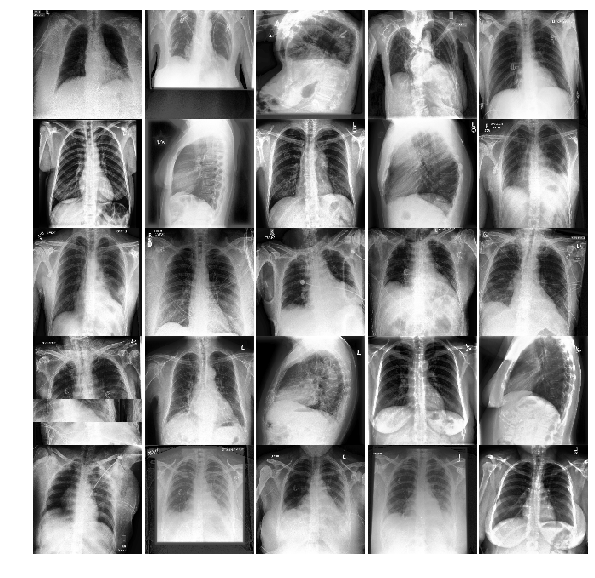

In [5]:
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in images[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

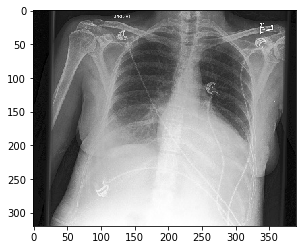

In [8]:
r = random.sample(images, 1)
plt.figure(figsize=(16,16))
plt.subplot(131)
plt.imshow(cv2.imread(r[0]))

In [61]:
imageid = (labels.iloc[:100])
CorelatedDiseases1 = ['Path','Lung Opacity','Edema']
CorelatedDiseases2 = ['Path','Lung Opacity','Consolidation','Pneumonia']
CorelatedDiseases3 = ['Lung Opacity','Lung Lesion']
CorelatedDiseases4 = ['Enlarged Cardiomediastinum','Cardiomegaly']
CorelatedDiseases5 = ['Lung Opacity','Atelectasis']
CorelatedDiseases6 = ['Lung Opacity','Pneumonia']
CorelatedDiseases7 = ['No Finding']
CorelatedDiseases8 = ['Support Devices']
CorelatedDiseases9 = ['Fracture']
CorelatedDiseases10 = ['Pneumothorax','Pleural Effusion','Pleural Other']
print(CorelatedDiseases1)
imageid = imageid[CorelatedDiseases1]
imageid['Path'] = imageid['Path'].str.replace('/','')
list(imageid['Path'])

['Path', 'Lung Opacity', 'Edema']


['CheXpert-v1.0-smalltrainpatient00001study1view1_frontal.jpg',
 'CheXpert-v1.0-smalltrainpatient00002study2view1_frontal.jpg',
 'CheXpert-v1.0-smalltrainpatient00002study1view1_frontal.jpg',
 'CheXpert-v1.0-smalltrainpatient00002study1view2_lateral.jpg',
 'CheXpert-v1.0-smalltrainpatient00003study1view1_frontal.jpg',
 'CheXpert-v1.0-smalltrainpatient00004study1view1_frontal.jpg',
 'CheXpert-v1.0-smalltrainpatient00004study1view2_lateral.jpg',
 'CheXpert-v1.0-smalltrainpatient00005study1view1_frontal.jpg',
 'CheXpert-v1.0-smalltrainpatient00005study1view2_lateral.jpg',
 'CheXpert-v1.0-smalltrainpatient00005study2view1_frontal.jpg',
 'CheXpert-v1.0-smalltrainpatient00005study2view2_frontal.jpg',
 'CheXpert-v1.0-smalltrainpatient00006study1view1_frontal.jpg',
 'CheXpert-v1.0-smalltrainpatient00007study1view1_frontal.jpg',
 'CheXpert-v1.0-smalltrainpatient00007study2view1_frontal.jpg',
 'CheXpert-v1.0-smalltrainpatient00008study1view1_frontal.jpg',
 'CheXpert-v1.0-smalltrainpatient00008st

In [86]:



def proc_images():
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """
    
    x = [] # images as arrays
    y = [] # labels
    WIDTH = 128
    HEIGHT = 128
    for img in images[:100]:
        # Read and resize image
        imid = img.replace('\\','')
        mylabel = int(imageid.loc[imageid['Path']== imid]['Lung Opacity'].values)
        mylabel1 =int(imageid.loc[imageid['Path']== imid]['Edema'].values)
        mylabel = (mylabel*1)+(mylabel1*2)
        full_size_image = cv2.imread(img)
        x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
        y.append(mylabel)
       
    return x,y


In [88]:
X,y = proc_images()
df = pd.DataFrame()
df["images"]=X
df["labels"]=y
print(len(df), df.images[0].shape)
df.head()

100 (128, 128, 3)


,images,labels
0,"[[[2, 2, 2], [48, 48, 48], [52, 52, 52], [47, ...",0
1,"[[[17, 17, 17], [18, 18, 18], [45, 45, 45], [8...",1
2,"[[[185, 185, 185], [161, 161, 161], [160, 160,...",1
3,"[[[19, 19, 19], [18, 18, 18], [13, 13, 13], [2...",1
4,"[[[4, 4, 4], [3, 3, 3], [6, 6, 6], [2, 2, 2], ...",2
